# XRR Oscillation analysis

This is a nabbreviated explanation, see the references below for more detail. Bi-layer XRR oscillations are given by
$$ \sim \cos\left( l \sqrt{q^2-q_c^2}\right),$$
where $l$ is the layer surface distance and $q_c$ is the momentum transfer corresponding to the critical angle. With $x$ defined as
$$ x = \frac{1}{2\pi}\sqrt{q^2-q_c^2}, $$
we can find $l$ as the singular peak in the the fourier transform
$$\int \cos\left(2\pi l x\right)\, e^{-i2\pi l' x}\;dx = \frac{1}{2}\delta\left( l'-l\right),\quad \text{for }\; l'>0.$$

## Bibliography

K. Sakurai and A. Iida, "Layer thickness determination of thin films by grazing incidence X-ray experiments using interference effect", [Advances in X-ray Analysis **35**(B), 813-818 (1991)](https://www.cambridge.org/core/journals/advances-in-x-ray-analysis/article/abs/layer-thickness-determination-of-thin-films-by-grazing-incidence-xray-experiments-using-interference-effect/B481EF87930950A7AF95AB4F35F00112)

O. Duran, "Characterization of multilayered materials for optoelectronic components by high-resolution X-ray diffractometry and reflectometry: contribution of numerical treatments", [Thin solid films **450**(1), 51-59 (2004)](https://doi.org/10.1016/j.tsf.2003.10.052)

M. Lammel et al., "Fast Fourier transform and multi-Gaussian fitting of XRR data to determine the thickness of ALD grown thin films within the initial growth regime", [Applied Physics Letters **117**(21), 213106 (2020)](https://pubs.aip.org/aip/apl/article-pdf/doi/10.1063/5.0024991/14542525/213106_1_online.pdf)

## Preamble

In [3]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import Layout
import ipywidgets as widgets

from scipy.fft import fft, fftshift, fftfreq
from scipy.interpolate import interp1d
from scipy.signal import butter
from scipy.signal import sosfilt
from scipy.optimize import curve_fit

In [4]:
#data=np.loadtxt('Si_oxidation/Teflon_XRR.txt',skiprows=2)
#data=np.loadtxt('Si_oxidation/Si_Pt_B3_01.asc',skiprows=76, max_rows=57, delimiter=',').flatten()
#data=np.concatenate((data,np.loadtxt('Si_oxidation/Si_Pt_B3_01.asc',skiprows=133, max_rows=1, delimiter=',').flatten()))
#data=np.loadtxt('Si_oxidation/RSL_SG_20230426_0209.txt', skiprows=2)
data=np.loadtxt('Pt_sputtering/Si_Pt_B1_01.xy')
wl = 0.154 #nm

In [14]:
th = data.T[0]/2 #2theta -> theta in deg

y = data.T[1]

[None, Text(0, 0.5, '$R$'), Text(0.5, 0, '$\\theta\\quad[\\mathrm{deg.}]$')]

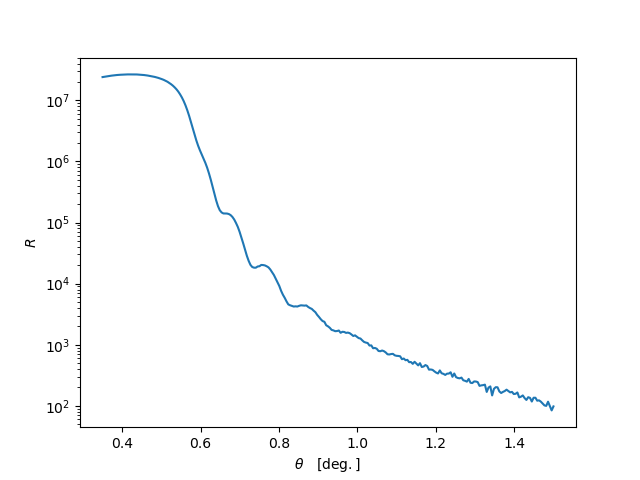

In [15]:
fig0,ax0 = plt.subplots()

ax0.plot(th,y)

ax0.set(yscale='log', ylabel='$R$', xlabel='$\\theta\quad[\mathrm{deg.}]$')

In [16]:
# Estimate critical angle from the plot
th_c = 0.5 #Critical angle (theta), deg

# Oscillations are ~cos(d sqrt(theta^2-theta_c^2)/lambda), so we need to scale the x axis accordingly

# Sakurai version
#x = 2*np.sqrt((th*np.pi/180)**2-(th_c*np.pi/180)**2)/wl  #convert to rad and correct x axis for oscillations (given critical angle)

# Durand version, slower but practically identical. Switch to Sakurai for faster performance. 
x = 2*np.sqrt(np.cos(th_c*np.pi/180)**2-np.cos((th*np.pi/180))**2)/wl 

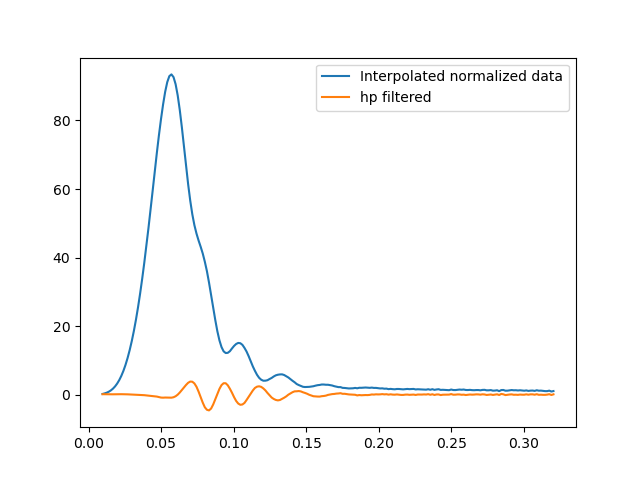

In [17]:
# intensity goes roughly as 1/x^4. Normalize by multiplying by x^4. Should be q rather than x? Read up on this.
y_norm=np.power(x,4)*y

# We need to resample the signal to uniform x steps (alternatively, we could use chirp z-transform instead of fft)
xmin=np.nanargmin(x) #get rid of values where x<0.
xmax=np.nanargmax(x)
x_uniform = np.linspace(x[xmin],x[xmax],xmax-xmin)

# Interpolate to uniform sampling
interp = interp1d(x[xmin:], y_norm[xmin:], kind='cubic')
y_uniform = interp(x_uniform)

fs= (xmax-xmin)/(x[xmax]-x[xmin]) #sample rate

# To get rid of the low frequency noise, pass the signal through a hp filter.
filter_order = 4
filter_cutoff = 40
sos = butter(filter_order, filter_cutoff, 'hp', fs=fs, output='sos')
y_filtered =  sosfilt(sos, y_uniform)

fig1, ax1 = plt.subplots()

ax1.set(yscale='linear')
ax1.plot(x_uniform,y_uniform, label = 'Interpolated normalized data')
ax1.plot(x_uniform, y_filtered , label='hp filtered')
ax1.legend()

In [18]:
#Functions to update FT plot with slider actions

def update_fig2_cutoff(change):
    global filter_cutoff
    global sos
    global y_filtered
    global FT_filtered
    
    filter_cutoff = change.new
    
    sos = butter(filter_order, filter_cutoff, 'hp', fs=fs, output='sos')
    y_filtered =  sosfilt(sos, y_uniform)
    
    FT_filtered = np.abs(fftshift(fft(y_filtered, n=n)))[n//2:]
    filt_plot[0].set_data(d,FT_filtered/FT_filtered.max())
    
def update_fig2_order(change):
    #global filter_cutoff
    global filter_order
    global y_filtered
    global FT_filtered
    global sos
    
    filter_order = change.new
    
    sos = butter(filter_order, filter_cutoff, 'hp', fs=fs, output='sos')
    y_filtered =  sosfilt(sos, y_uniform)
    #unfilt_plot.set_data(FT_unfiltered/FT_unfiltered.max(), label='Unfiltered')
    FT_filtered = np.abs(fftshift(fft(y_filtered, n=n)))[n//2:]
    filt_plot[0].set_data(d,FT_filtered/FT_filtered.max())

def update_fig2_th_c(change):
    
    global th_c
    global x
    global x_uniform
    global y_norm
    global interp
    global y_uniform
    global fs
    global y_filtered
    global FT_filtered
    global FT_unfiltered
    #global th_c_slider
    
    th_c = change.new #Critical angle (theta), deg to rad
    
    #Sakurai version
    #x = 2*np.sqrt((th*np.pi/180)**2-(th_c*np.pi/180)**2)/wl
    
    #Durand version
    x = 2*np.sqrt(np.cos(th_c*np.pi/180)**2-np.cos((th*np.pi/180))**2)/wl 
    
    xmin=np.nanargmin(x)
    xmax=np.nanargmax(x)
    x_uniform = np.linspace(x[xmin],x[xmax],xmax-xmin)

    # intensity goes roughly as 1/x^4. Normalize by multiplying by x^4.
    y_norm=np.power(x,4)*y

    # Interpolate to uniform sampling
    interp = interp1d(x[xmin:], y_norm[xmin:], kind='cubic')
    y_uniform = interp(x_uniform)

    fs= (xmax-xmin)/(x[xmax]-x[xmin]) #sample rate
    
    y_filtered =  sosfilt(sos, y_uniform)
    
    FT_unfiltered = np.abs(fftshift(fft(y_uniform, n=n)))[n//2:]#[x_uniform.shape[-1]//2:]
    FT_filtered = np.abs(fftshift(fft(y_filtered, n=n)))[n//2:]#[x_uniform.shape[-1]//2:]
    
    filt_plot[0].set_data(d, FT_filtered/FT_filtered.max())
    unfilt_plot[0].set_data(d, FT_unfiltered/FT_unfiltered.max())

def update_fig2_n(change):
    global n
    global FT_filtered
    global FT_unfiltered
    global d
    
    n = change.new
    
    FT_unfiltered = np.abs(fftshift(fft(y_uniform, n=n)))[n//2:]#[x_uniform.shape[-1]//2:]
    FT_filtered = np.abs(fftshift(fft(y_filtered, n=n)))[n//2:]#[x_uniform.shape[-1]//2:]
    d =fftshift(fftfreq(n,x_uniform[1]-x_uniform[0]))[n//2:]
    
    filt_plot[0].set_data(d, FT_filtered/FT_filtered.max())
    unfilt_plot[0].set_data(d, FT_unfiltered/FT_unfiltered.max())
    
def update_guess(change):
    global guess
    global guess_line
    
    guess = change.new
    guess_line.set_xdata([guess,guess])
    
def gauss(x,A,a,mu,b):
    return A*np.exp(-(a*(x-mu))**2)+b

def update_fit(b):

    global fit_curve
    
    range_ind = (d>guess-50) & (d<guess+50)
    fit_d = d[range_ind]
    fit_inds = np.arange(d.shape[0])[range_ind]
    
    fit = curve_fit(gauss,fit_d,FT_filtered[fit_inds]/FT_filtered.max(), p0=[1,1e-2,guess,0], bounds=([0,0,0,0],[1,np.inf,d[-1],np.inf]))
    
    plot_x=np.linspace(fit_d[0],fit_d[-1],500)
    fit_curve[0].set_data(plot_x,gauss(plot_x,*fit[0]))
    
    fit_output.clear_output()
    with fit_output:
        print('Center: ',fit[0][2], ' nm')
        print('HWHM: ', np.sqrt(-np.log(0.5-fit[0][-1]))/fit[0][1], 'nm')

FloatSlider(value=0.5, description='Critical angle', layout=Layout(width='500px'), max=1.0, readout_format='.3…

IntSlider(value=40, description='Filter cutoff', layout=Layout(width='500px'), max=346, min=1)

IntSlider(value=4, description='Filter order', layout=Layout(width='500px'))

IntSlider(value=500, description='fft output bins', layout=Layout(width='500px'), max=2000, min=1)

FloatSlider(value=0.0, description='Fit position guess ', layout=Layout(width='500px'), max=346.0017465345635,…

Button(description='Fit', style=ButtonStyle())

Output()

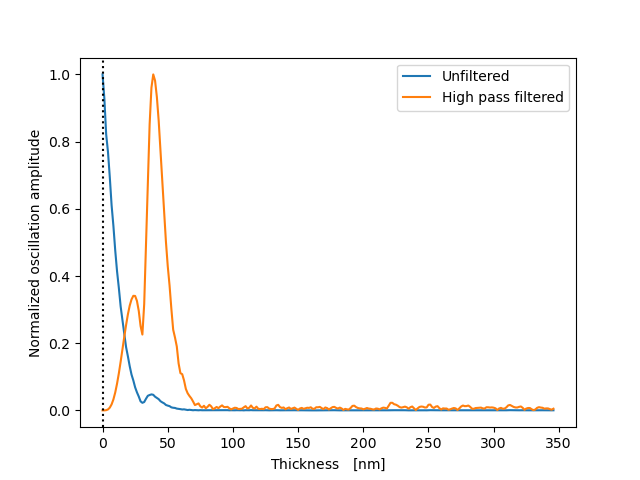

In [19]:
fig2, ax2 = plt.subplots()

plt.ion()

slider_length='500px'

n = 500 #number of points in fft output
guess =0

FT_unfiltered = np.abs(fftshift(fft(y_uniform, n=n)))[n//2:]#[x_uniform.shape[-1]//2:]
FT_filtered = np.abs(fftshift(fft(y_filtered, n=n)))[n//2:]#[x_uniform.shape[-1]//2:]
#d = fftshift(fftfreq(x_uniform.shape[-1],n)#x_uniform[1]-x_uniform[0]))[x_uniform.shape[-1]//2:]
d =fftshift(fftfreq(n,x_uniform[1]-x_uniform[0]))[n//2:]
            
unfilt_plot = ax2.plot(d,FT_unfiltered/FT_unfiltered.max(), label='Unfiltered')
filt_plot = ax2.plot(d,FT_filtered/FT_filtered.max(), label='High pass filtered')

guess_line = ax2.axvline(x=guess, color='k', linestyle='dotted')

fit_curve = ax2.plot(0,0,color='k', linestyle='dashed')

ax2.legend()
ax2.set(ylabel='Normalized oscillation amplitude', xlabel='Thickness$\quad[\mathrm{nm}]$')#, yscale='log')

cutoff_slider = widgets.IntSlider(min=1,max=d.max(),step=1,value=filter_cutoff, description='Filter cutoff', layout=Layout(width=slider_length))
cutoff_slider.observe(update_fig2_cutoff, names='value')

order_slider = widgets.IntSlider(min=0,max=100,step=1,value=filter_order , description='Filter order', layout=Layout(width=slider_length))
order_slider.observe(update_fig2_order, names='value')

th_c_slider = widgets.FloatSlider(min=0,max=1,step=1e-3,value=th_c, readout_format='.3f', description='Critical angle', layout=Layout(width=slider_length))
th_c_slider.observe(update_fig2_th_c, names='value')

n_slider = widgets.IntSlider(min=1,max=2000,step=1,value=n , description='fft output bins', layout=Layout(width=slider_length))
n_slider.observe(update_fig2_n, names='value')

guess_slider = widgets.FloatSlider(min=0,max=d[-1],step=1e-3,value=0, readout_format='.3f', description='Fit position guess ', layout=Layout(width=slider_length))
guess_slider.observe(update_guess, names='value')

fit_button = widgets.Button(description='Fit')
fit_output = widgets.Output()
fit_button.on_click(update_fit)

display(th_c_slider, cutoff_slider, order_slider, n_slider, guess_slider, fit_button, fit_output)

## Precharacterization results

### SiO<sub>2</sub> on Si

Wafers baked at 1000 degrees C.

Critical angle lit. value for SiO2: 0.239 degrees, http://gisaxs.com/index.php/Material:Silicon_dioxide

#### 1h baking
Film tickness: 77 +- 2 nm\
Critical angle: 0.215 degrees (theta)

#### 2h baking
Film thickness: 98 +- 2 nm\
Critical angle: 0.215 degrees

#### 3h baking
Film thickness: 87 +- 1 nm\
Critical angle: 0.238 degrees.

### Pt on Si

Reference simulated curve\
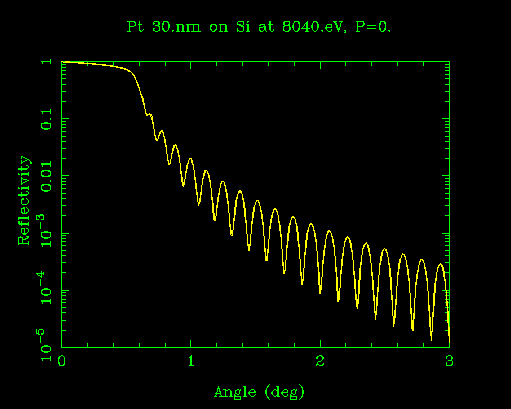

#### 30 nm acc. to quartz microbalance
Film thickness: 55 +- 7 nm\
Critical angle: 0.494 degrees.

Angle very hard to dial in. I believe surface roughness leads to a large spread in incidence angles.

#### 15 nm acc. to quartz microbalance

##### Wafer 1
Film thickness: 36 +- 5 m,
Critical angle: 0.555 degrees.

##### Wafer 2
Film thickness: 36 +- 7 m,
Critical angle: 0.420 degrees.

##### Wafer 2
Film thickness: 27 +- 4 m,
Critical angle: 0.506 degrees.